In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 507ms/step - loss: 0.5433 - root_mean_squared_error: 0.7371 - val_loss: 0.2683 - val_root_mean_squared_error: 0.5179
Epoch 2/50
53/53 [==============================] - 25s 486ms/step - loss: 0.1242 - root_mean_squared_error: 0.3524 - val_loss: 0.1466 - val_root_mean_squared_error: 0.3829
Epoch 3/50
53/53 [==============================] - 26s 495ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3773
Epoch 4/50
53/53 [==============================] - 25s 487ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823 - val_loss: 0.1323 - val_root_mean_squared_error: 0.3637
Epoch 5/50
53/53 [==============================] - 26s 492ms/step - loss: 0.0737 - root_mean_squared_error: 0.2715 - val_loss: 0.1241 - val_root_mean_squared_error: 0.3523
Epoch 6/50
53/53 [==============================] - 26s 497ms/step - loss: 0.0698 - root_mean_squared_error: 0.2643 - val_loss: 0.1165 

Epoch 27/50
53/53 [==============================] - 26s 504ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1514
Epoch 28/50
53/53 [==============================] - 26s 501ms/step - loss: 0.0209 - root_mean_squared_error: 0.1447 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1447
Epoch 29/50
53/53 [==============================] - 3s 65ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1589
Epoch 30/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 31/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0203 - root_mean_squared_error: 0.1423 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 32/50
53/53 [==============================] - 3s 66ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0214 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

13.742235851287841 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

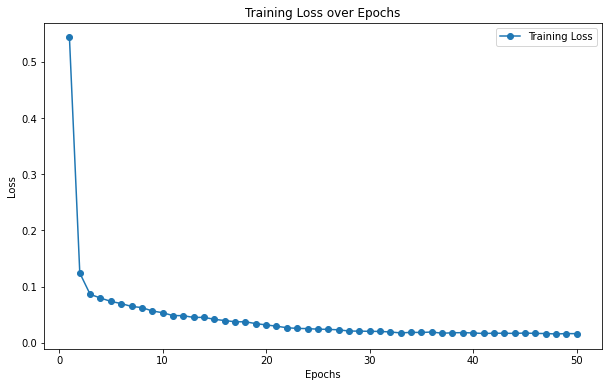

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

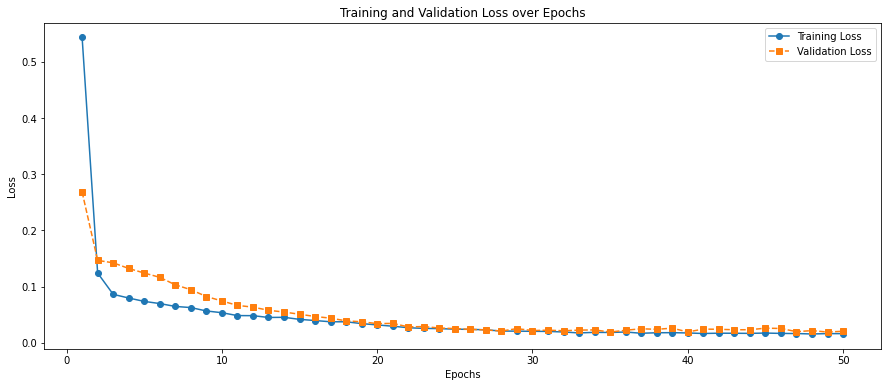

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 23ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.12469898587876388
MAE : 0.09285262925984307


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

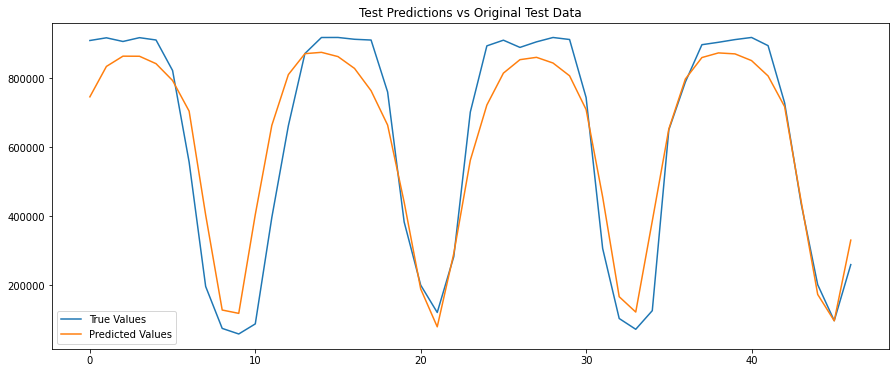

In [19]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [20]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 36ms/step


In [21]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

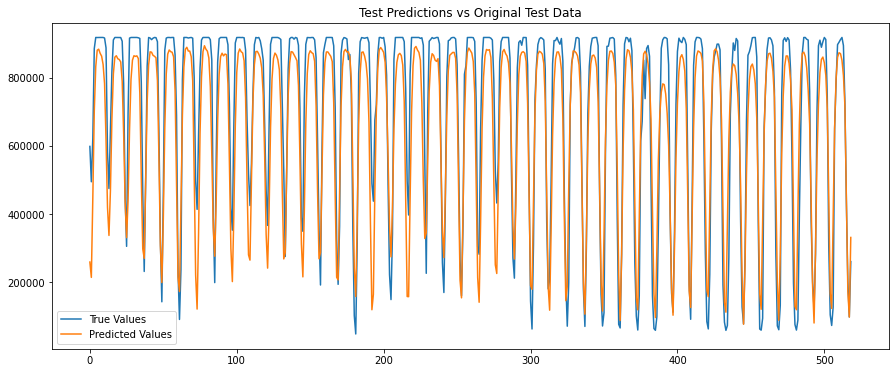

In [22]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()